In [ ]:
!unzip /content/test1.zip

In [ ]:
import os
import glob
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from keras.models import load_model
from keras.preprocessing import image
from keras.models import Model
from keras import losses
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

Using TensorFlow backend.


In [ ]:
import random
import sys
import dlib
import cv2
import os

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
TRAIN_IMAGES = glob.glob('/content/drive/My Drive/colab_data/cat_data/train_cat/*.jpg')
CLEAN_IMAGES = glob.glob('/content/drive/My Drive/colab_data/cat_data/train_cat/*.jpg')
TEST_IMAGES = glob.glob('/content/drive/My Drive/colab_data/test_images/*.jpeg')

In [ ]:
####################landmarks#########################################################################################################

In [ ]:
df=pd.read_csv("/content/sample_data/california_housing_train.csv")

In [ ]:
train_lmks= {'tr_lmks': []}

In [ ]:
os.chdir('/content/drive/My Drive/colab_data') 

In [ ]:
  base_path = os.getcwd() + "/" 
  file_list = sorted(os.listdir(base_path))
  random.shuffle(file_list)
  pd_frame = pd.read_csv(os.path.join(base_path, 'training_human_32x32.csv'))

In [ ]:
for i in range(0, 1713):
  
  landmark = (pd_frame.as_matrix()[i][0:6]).reshape((-1, 2))
  train_lmks['tr_lmks'].append(landmark.flatten())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
np.save('/content/drive/My Drive/colab_data/' + 'tr_lmks.npy', np.array(train_lmks))

In [ ]:
data_00 = np.load('/content/drive/My Drive/colab_data/tr_lmks.npy',allow_pickle=True)
hy_train = np.array(data_00.item().get('tr_lmks'))
hy_train.shape

(1713, 6)

In [ ]:
##########################################################################################################################

In [ ]:
def load_image(path):
    image_list = np.zeros((len(path),32,32, 3))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='rgb', target_size=(32,32))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

In [ ]:

x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)

print(x_train.shape, x_test.shape)

(770, 32, 32, 3) (1713, 32, 32, 3)


In [ ]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape, x_val.shape)

(616, 32, 32, 3) (154, 32, 32, 3)


In [ ]:
data_01 = np.load('/content/drive/My Drive/colab_data/tr_new.npy',allow_pickle=True)

In [ ]:
img_size=32
output_size=6
hx_train = np.array(data_00.item().get('tr_imgs'))
hy_train = np.array(data_00.item().get('tr_lmks'))
hx_train = x_train.astype('float32') / 255.
hx_train = np.reshape(x_train, (-1, img_size, img_size, 1))
hy_train = np.reshape(y_train, (-1, output_size))

In [ ]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.0003)
        
        self.autoencoder_model, self.subModel = self.build_model() 
        self.reg=self.reg_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(300, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        h = Conv2D(250,(3,3),activation='relu',padding='same')(h)
        h=MaxPooling2D((2,2),padding='same')(h)
        h=Conv2D(200,(3,3),activation='relu',padding='same')(h)
        h=Conv2D(150,(3,3),activation='relu',padding='same')(h)
        h=Conv2D(100,(3,3),activation='relu',padding='same')(h)
        h=Dense(500, activation='relu', name='submodel')(h)
        encoder = Model(input_layer,h)
        # decoder
        h=Dense(500)(h)
        h = Conv2D(100, (3, 3), activation='relu', padding='same')(h)
        h=Conv2D(150,(3,3),activation='relu',padding='same')(h)
        h=Conv2D(200,(3,3),activation='relu',padding='same')(h)
        h =Conv2D(250,(3,3),activation='relu',padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        h = Conv2D(300, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(3, (3, 3), activation='tanh', padding='same')(h)
        
        model = Model(input_layer, output_layer)
        
        subModel = Model(model.input, model.get_layer('submodel').output)
        
        return model, subModel
    
    def reg_model(self):
      input_layer= Input(shape=(8,8,500))
      h= Flatten()(input_layer)
      regression_layer= Dense(6, activation='linear')(h)
      reg= Model(input_layer, regression_layer)
      reg.summary()
      return reg
    
    def human_train(self, hx_train, hy_train, epochs, batch_size=128):
      optimizer = Adam(lr=0.0003)
      self.reg.compile(optimizer, loss=losses.mean_squared_error,metrics=["accuracy"])
      self.reg.fit(hx_train, hy_train, epochs=20, batch_size=batch_size, shuffle=True, verbose=1)
      self.reg.save('reg_model.h5')
      
      
      
      
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=128):
        optimizer = Adam(lr=0.0003)
        self.autoencoder_model.compile(optimizer,loss=losses.mean_squared_error,metrics=["accuracy"])
        self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=100,
                                             verbose=1,
                                             validation_data=(x_val, y_val))
  
        self.autoencoder_model.save('ae2.h5')
        self.subModel.save('sub2.h5')
      
    def eval_reg(self, x1_test):
        pred_reg=self.reg.predict(x1_test)
        return pred_reg

       
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        predictions = self.subModel.predict(x_test)
        return preds, predictions

In [ ]:
ae = Autoencoder()
ae.train_model(x_train, y_train, x_val, y_val, epochs=100, batch_size=128)

ae.human_train(predictions, hy_train, epochs=100, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 8, 8, 500)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 192006    
Total params: 192,006
Trainable params: 192,006
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 300)       8400      
_________________________________________________________________
max_

ValueError: ignored

In [ ]:
model=load_model("ae1.h5")
model.compile(optimizer="adam",loss=losses.mean_squared_error,metrics=["accuracy"])
# model.fit(x_train, y_train,batch_size=128,epochs=50,validation_data=(x_val, y_val))

In [ ]:
preds, predictions = ae.eval_model(x_test)
pred_reg = ae.eval_reg(predictions)
pred_reg.shape

(1713, 6)

In [ ]:
predictions.shape

(1713, 8, 8, 500)

In [ ]:
preds_0 = preds[9].reshape(32,32,3)
x_test_0 = x_test[9] * 255.0
x_test_0 = x_test_0.reshape(32,32,3)
plt.imshow(x_test_0)



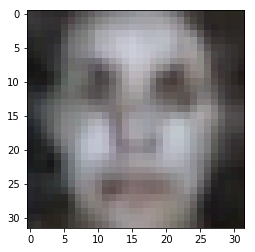

In [ ]:
plt.imshow(preds_0)